# SlideSeq Spatial Transcriptomics analysis of Muscle Regeneration 

As described at:
Integrated single-cell and spatial transcriptomic analysis of skeletal muscle regeneration 
Lauren Walter , Jessica Orton , E. H. Hannah Fong , Ms Viviana Maymi , Dr Brian Rudd , Dr Jennifer Elisseeff , Ioannis Ntekas , Iwijn De Vlaminck, Benjamin D. Cosgrove* 


ST analysis by Ioannis Ntekas 

email: in68@cornell.edu

## Import Packages


In [1]:
import squidpy as sq
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import scipy.spatial as scisp
from matplotlib.colors import ListedColormap
from scipy.stats import ttest_ind, mannwhitneyu, ranksums



import gc


###import functions from ST_utils.py
from ST_utils import *
gc.enable()

/home/in68/.local/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
sc.settings.verbosity = 3  
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5),vector_friendly=True, dpi_save=300)
# Font properties for the scale bar
fontprops = fm.FontProperties(size=10)
# Set global figure parameters for scanpy
sc.settings.set_figure_params(fontsize=7)

-----
anndata     0.10.3
scanpy      1.9.3
-----
PIL                         10.1.0
ST_utils                    NA
anyio                       NA
asciitree                   NA
asttokens                   NA
attr                        23.1.0
babel                       2.12.1
backcall                    0.2.0
brotli                      1.0.9
certifi                     2023.07.22
cffi                        1.15.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
comm                        0.1.3
cycler                      0.12.1
cython_runtime              NA
dask                        2023.12.1
dask_image                  2023.08.1
datashader                  0.15.2
datashape                   0.5.2
datatree                    0.0.12
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
exceptiongroup              1.2.0
executing                   

In [3]:
# Define colormap to use with light grey as the zero/ND value 
viridis = mpl.colormaps['viridis_r'].resampled(256)
newcolors = viridis(np.linspace(0, 1, 256))
light_grey = np.array([192/256, 192/256, 192/256, 1])
newcolors[:1, :] = light_grey
newcmp = ListedColormap(newcolors)


# Define colormap to use with light grey as the zero/ND value 
Reds = mpl.colormaps['Reds'].resampled(256)
newcolors = Reds(np.linspace(0, 1, 256))
light_grey = np.array([192/256, 192/256, 192/256, 1])
newcolors[:1, :] = light_grey
newcmp2 = ListedColormap(newcolors)

# Define colormap to use with light grey as the zero/ND value 
Magma = mpl.colormaps['magma'].resampled(256)
newcolors = Magma(np.linspace(0, 1, 256))
light_grey = np.array([192/256, 192/256, 192/256, 1])
newcolors[:1, :] = light_grey
newcmp3 = ListedColormap(newcolors)


# Define colormap to use with light grey as the zero/ND value 
inferno = mpl.colormaps['inferno'].resampled(256)
newcolors = inferno(np.linspace(0, 1, 256))
light_grey = np.array([192/256, 192/256, 192/256, 1])
newcolors[:1, :] = light_grey
newcmp4 = ListedColormap(newcolors)

In [4]:
# Load the Young and Geriatric object on a dictionary for easier handling 0:Y, 1:G

adata_dict = {}
Sample_list = [11,12]

for i in[0,1]:
    temp = sc.read_10x_mtx(f"/fs/cbsuvlaminck2/workdir/in68/Muscle/out/Sample{Sample_list[i]}/STARsolo/Solo.out/GeneFull/raw/")
    temp.write_h5ad(f"/fs/cbsuvlaminck2/workdir/in68/Muscle/out/Sample{Sample_list[i]}/STARsolo/Solo.out/GeneFull/raw/Sample_{Sample_list[i]}.h5ad")
    temp.raw = temp.copy()
    sc.pp.filter_cells(temp, min_counts = 20)
    # add cell2location prediction scores and related vars to the object --copy the .obsm, .uns 
    adata =sc.read_h5ad (f"/workdir/in68/Muscle/cell2location/cell2location_out/Muscle_{Sample_list[i]}_0301.h5ad")
    temp.obsm = adata.obsm
    temp.uns = adata.uns
    adata_dict[i] = temp
    adata_dict[i].var_names_make_unique()

    
    adata_dict[i].obs[adata_dict[i].uns['mod']['factor_names']] = adata_dict[i].obsm['q05_cell_abundance_w_sf']
    adata_dict[i].obsm['q05_cell_proportions'] = adata_dict[i].obsm['q05_cell_abundance_w_sf'].div(adata_dict[i].obsm['q05_cell_abundance_w_sf'].sum(axis=1), axis=0)

    adata_dict[i].obs["total_abundance"] = adata_dict[i].obsm['q05_cell_abundance_w_sf'].sum(axis = 1)
    # adata_dict[i].obs[adata_dict[i].uns['mod']['factor_names']] = adata_dict[i].obsm['q05_cell_abundance_w_sf']
    adata_dict[i].obs[adata_dict[i].uns['mod']['factor_names']] = adata_dict[i].obsm['q05_cell_proportions']
    adata_dict[i].obs["max_pred"] = adata_dict[i].obs[adata_dict[i].uns['mod']['factor_names']].max(axis=1)
    #Set max_pred_celltype as the dominant celltype based on cell2loc results
    adata_dict[i].obs["max_pred_celltype"] = adata_dict[i].obs[adata_dict[i].uns['mod']['factor_names']].idxmax(axis=1)
    adata_dict[i].obs["max_pred_celltype"] = adata_dict[i].obs["max_pred_celltype"].astype('category')




    #####Add spatial coordinates and then filer cells with less that 10 neighbors at 100um
    # Add spatial coords
    adata_dict[i] = add_spatial_coordinates(adata_dict[i], f"/fs/cbsuvlaminck2/workdir/in68/Utils/Curio_BB/A0018_0{Sample_list[i]}_BeadBarcodes.txt")
    # Convert distances to um
    adata_dict[i].obsm['spatial'] = adata_dict[i].obsm['spatial'] /1.54
    # Calculate euclidean distances
    adata_dict[i].obsm["spatial_distances"] = scisp.distance.squareform(scisp.distance.pdist(adata_dict[i].obsm['spatial']))
    # Filter smear/singlets
    adata_dict[i].obs["spatial_neighbors_100_true"] = np.sum(adata_dict[i].obsm["spatial_distances"] < 100, axis=0)
    adata_dict[i] = adata_dict[i][adata_dict[i].obs["spatial_neighbors_100_true"] > 10]
    
    # QC and filtering
    sc.pp.filter_genes(adata_dict[i], min_cells = 10)

    adata_dict[i].var["mito"] = adata_dict[i].var_names.str.startswith("Mt-")
    sc.pp.calculate_qc_metrics(adata_dict[i], qc_vars=["mito"], inplace=True)

    # Normalization
    sc.pp.normalize_total(
            adata_dict[i], 
            target_sum=1e4,
        inplace=True)
    sc.pp.log1p(adata_dict[i])
    
del temp 
 

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
filtered out 45486 cells that have less than 20 counts
Added spatial coordinates for 32156 cells.


/tmp/ipykernel_950049/141465032.py:37: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata_dict[i].obsm['spatial'] = adata_dict[i].obsm['spatial'] /1.54


filtered out 45026 genes that are detected in less than 10 cells


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


normalizing counts per cell
    finished (0:00:00)
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
filtered out 55540 cells that have less than 20 counts
Added spatial coordinates for 22972 cells.


/tmp/ipykernel_950049/141465032.py:37: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata_dict[i].obsm['spatial'] = adata_dict[i].obsm['spatial'] /1.54


filtered out 46805 genes that are detected in less than 10 cells


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


normalizing counts per cell
    finished (0:00:00)


### Define injury loci
Injury locus deffinition based on immune cell density and location

In [5]:
# Define injury locus based on the kNN approach. Calculate immune neighbors 

for adata in adata_dict.values():

    for celltype in np.unique(adata.obs['max_pred_celltype']):
        adata = calculate_celltype_neighbors(adata, 300, celltype, 'max_pred_celltype')
    
    adata.obs['Immune_neighbors'] = adata.obs['T cells_neighbors'] + adata.obs['B cells_neighbors'] + adata.obs['NK cells_neighbors'] + adata.obs['Dendritic cells_neighbors'] + adata.obs['Neutrophils_neighbors'] + adata.obs['Monocytes/Macrophages_neighbors']
gc.collect()   

200

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_ma

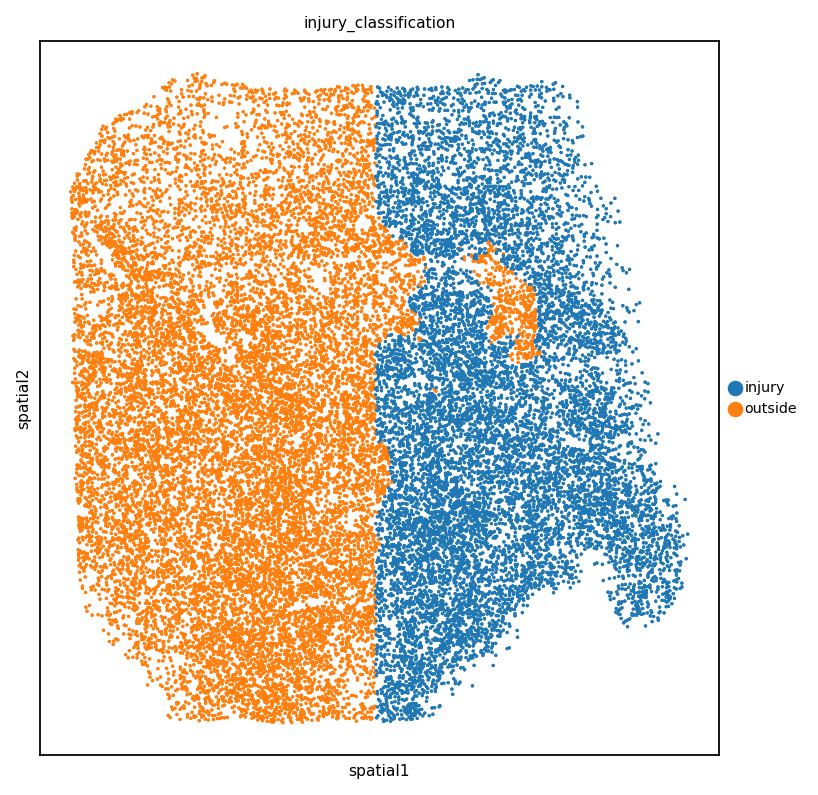

In [6]:
# Geriatric Muscle

mask = (adata_dict[1].obs["Immune_neighbors"] > 20) & (adata_dict[1].obsm["spatial"][:,0] > 1945)
adata_dict[1].obs['injury_classification'] = ''
idx = adata_dict[1][mask].obs.index
idx_rev = adata_dict[1][~mask].obs.index
adata_dict[1].obs.loc[idx_rev, 'injury_classification'] = 'outside'
adata_dict[1].obs.loc[idx, 'injury_classification'] = 'injury'

sq.pl.spatial_scatter(adata_dict[1],color ="injury_classification", size= 1, shape=None,figsize= [5,5],cmap=newcmp,vmin = 0.4)

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_ma

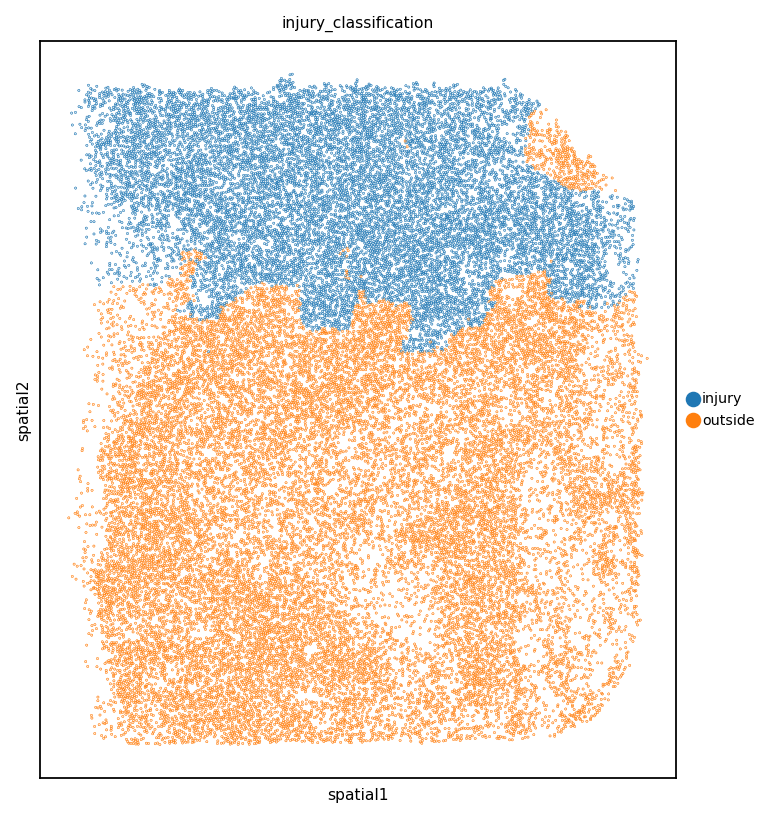

In [7]:
# Young Muscle 

mask = (adata_dict[0].obs["Immune_neighbors"] > 20) & (adata_dict[0].obsm["spatial"][:,1] < 1500)
adata_dict[0].obs['injury_classification'] = ''
idx = adata_dict[0][mask].obs.index
idx_rev = adata_dict[0][~mask].obs.index
adata_dict[0].obs.loc[idx_rev, 'injury_classification'] = 'outside'
adata_dict[0].obs.loc[idx, 'injury_classification'] = 'injury'

sq.pl.spatial_scatter(adata_dict[0],color ="injury_classification", size= 0.1, shape=None,figsize= [5,5],cmap=newcmp,vmin = 0.4)

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_ma

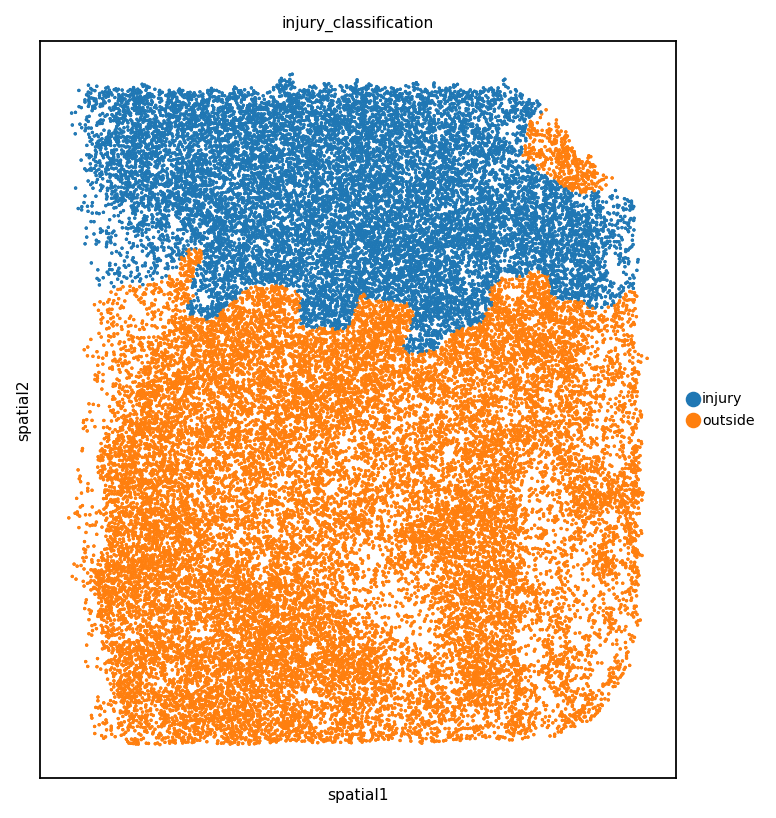

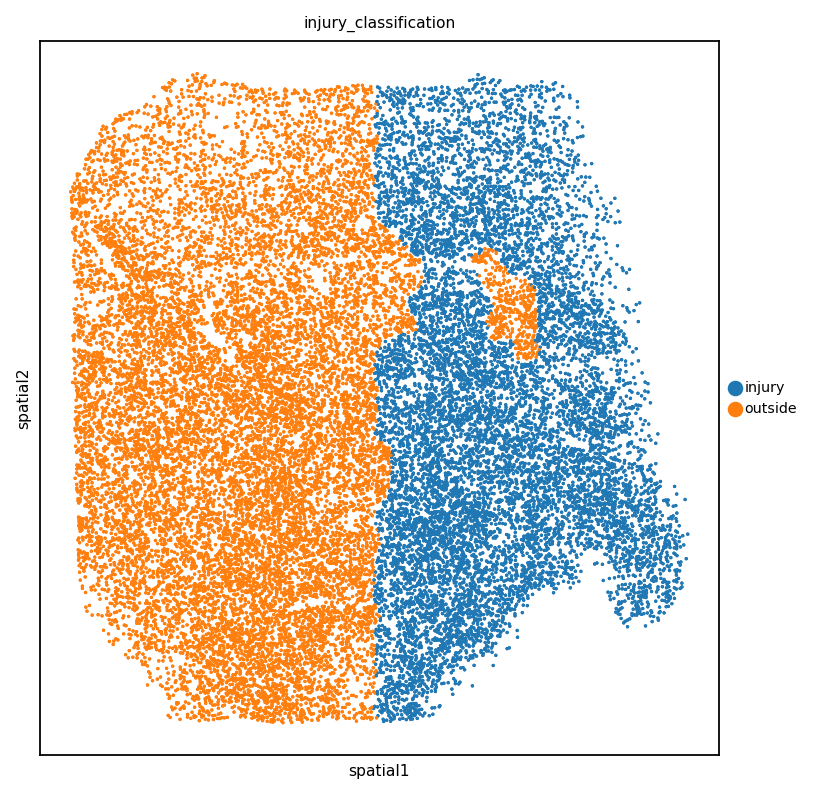

In [8]:
##Discard singlets/small islands
for adata in adata_dict.values():
    adata= calculate_celltype_neighbors(adata, 20, celltype_label='injury',cell_obs='injury_classification')
    mask = adata.obs["injury_neighbors"] > 10
    idx = adata[mask].obs.index
    idx_rev = adata[~mask].obs.index
    adata.obs.loc[idx_rev, 'injury_classification'] = 'outside'
    adata.obs.loc[idx, 'injury_classification'] = 'injury'
    
sq.pl.spatial_scatter(adata_dict[0],color ="injury_classification", size= 1, shape=None,figsize= [5,5],cmap=newcmp,vmin = 0.4)
sq.pl.spatial_scatter(adata_dict[1],color ="injury_classification", size= 1, shape=None,figsize= [5,5],cmap=newcmp,vmin = 0.4)

### Define cell type and injury locus colors 

In [9]:
celltype_colors = [
    '#F20A53',
    '#9C6DA5',
    '#2E3B65',
    '#3C0AAA',
    '#8BA690',
    '#067F71',
    '#891B5A',
    '#FA78FA',
    '#C85A00',
    '#076594',
    '#709EB5',
    '#826E00',
    '#5078FA',
    '#AFE4DE',
    '#793EA8'
]  
loc_colors =  ['#EC4F38','#2B8076']




 
adata_dict[0].uns['max_pred_celltype_colors'] = celltype_colors
adata_dict[0].uns['loc_colors'] = loc_colors
adata_dict[1].uns['max_pred_celltype_colors'] = celltype_colors
adata_dict[1].uns['loc_colors'] = loc_colors

### Make barplots for cell abundances in spatial data 

In [10]:
###Store normalization info as uns
for i in[0,1]:
    total_beads = len(adata_dict[i].obs)
    injury = len(adata_dict[i][adata_dict[i].obs['injury_classification'] == 'injury' ].obs)
    outside = len(adata_dict[i][adata_dict[i].obs['injury_classification'] != 'injury' ].obs)
    
    adata_dict[i].uns['total_beads'] = total_beads
    adata_dict[i].uns['injury'] = injury
    adata_dict[i].uns['outside'] = outside


In [ ]:
#os.chdir('/workdir/in68/Muscle/figs/')

/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

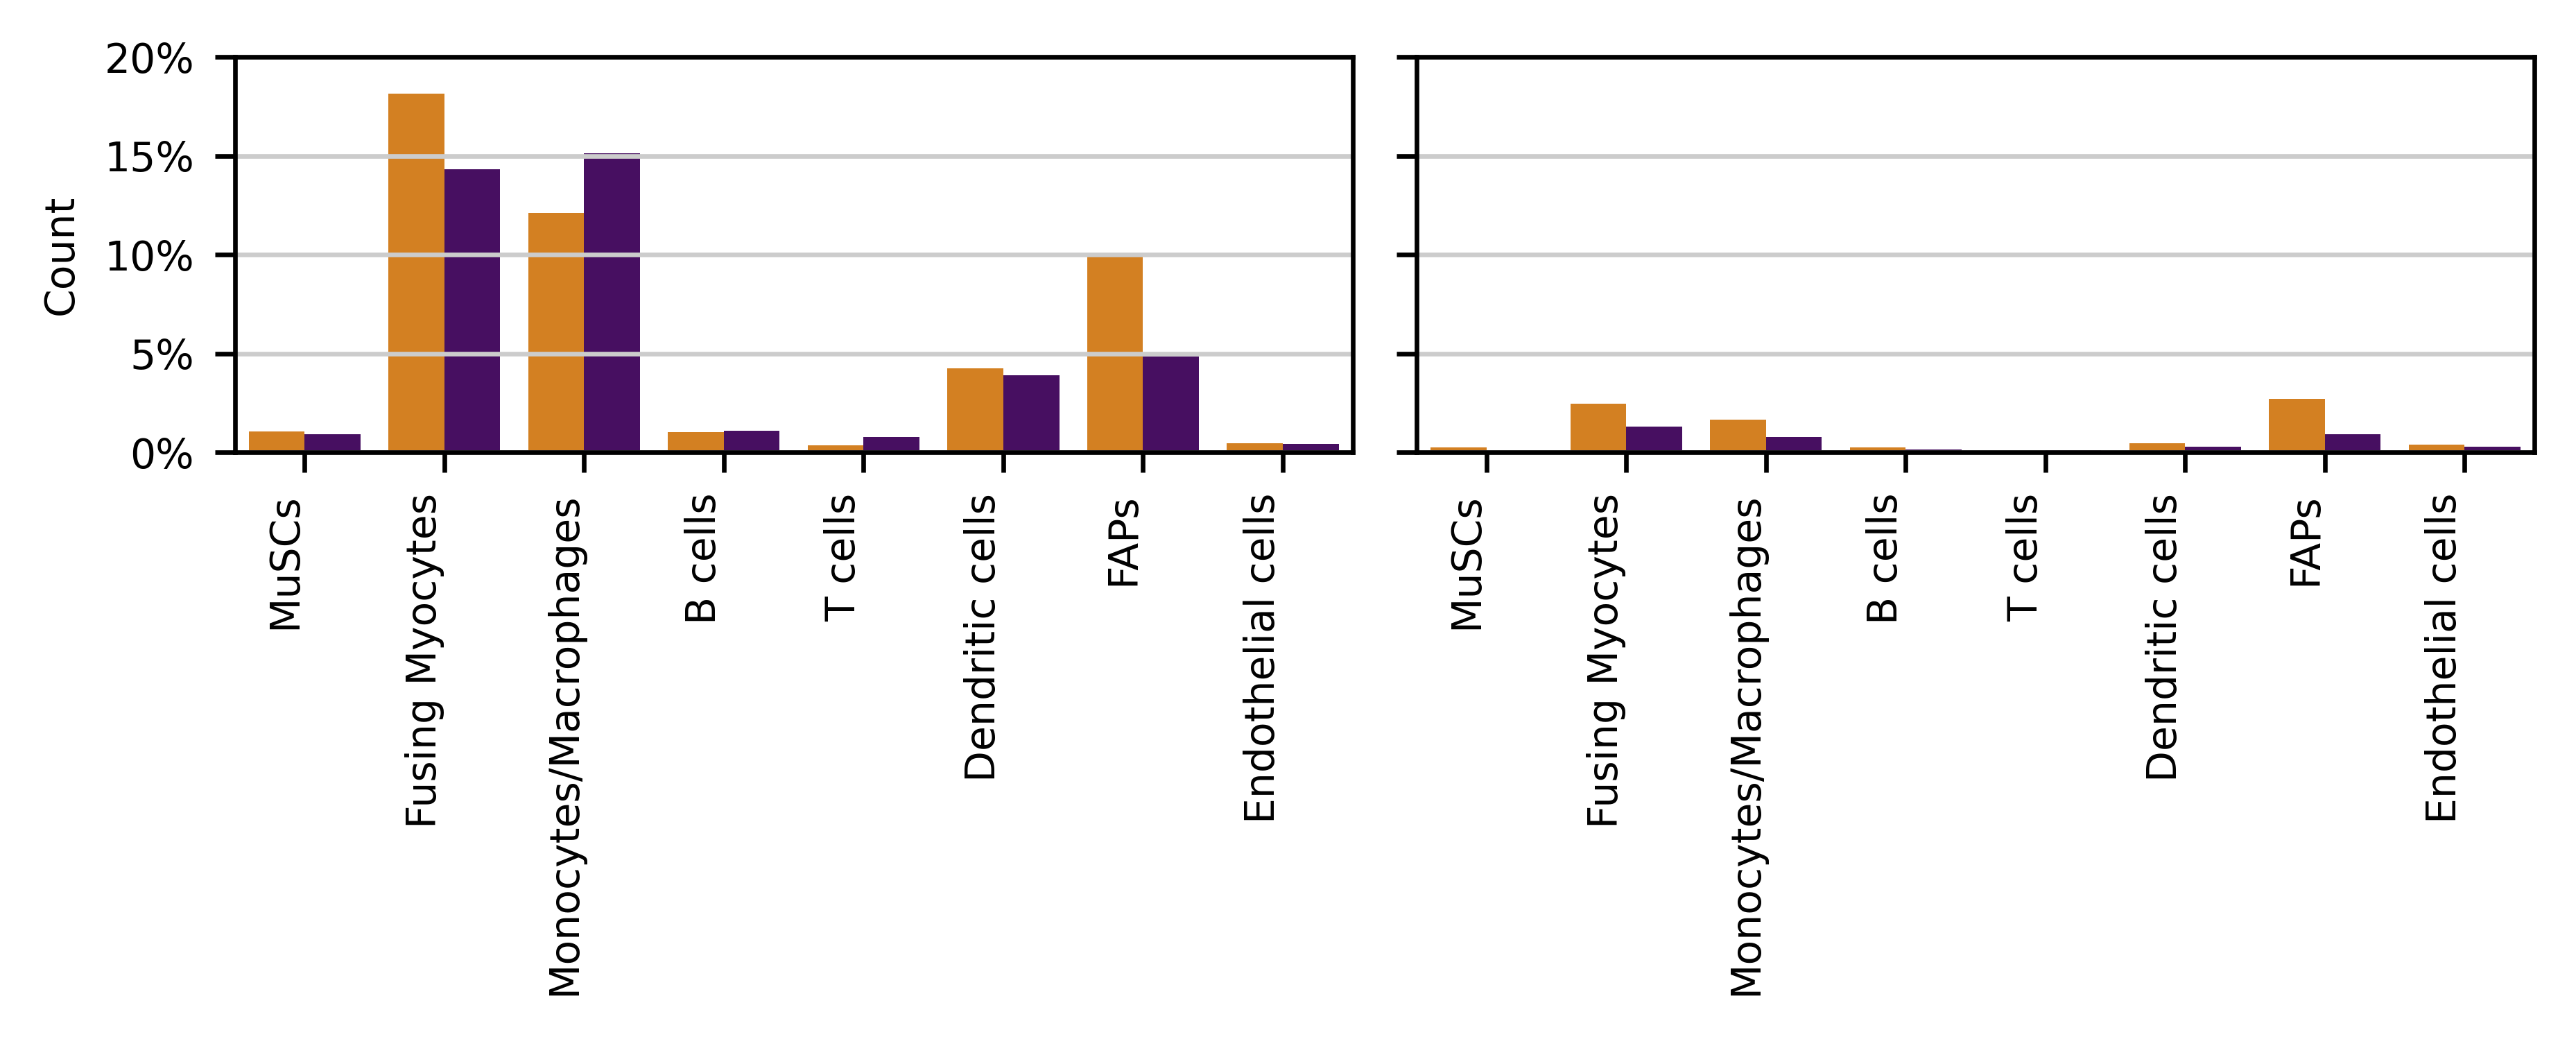

In [11]:
# Custom font settings
plt.rcParams.update({'font.size': 7})  # Set global font size

# Function to format the y-axis ticks as percentages
def to_percentage(x, pos):
    return f'{int(x)}%'

formatter = FuncFormatter(to_percentage)

# Define the subset of cell types to include in the plot in the specified order
cell_types_subset = ['MuSCs', 'Fusing Myocytes', 'Monocytes/Macrophages', 'B cells', 'T cells', 'Dendritic cells', 'FAPs', 'Endothelial cells']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.2, 2.5), dpi=300)  # Total size of the figure
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.15)  # Adjust space to optimize layout

for i, location in enumerate(np.unique(adata_dict[0].obs['injury_classification'])):
    category = location
    colors = ['#F08205', '#4C026E']
    dataset_names = ['Young', 'Geriatric']
    
    cell_type_counts = {}
    for idx, (key, adata) in enumerate(adata_dict.items()):
        adata = adata[adata.obs['injury_classification'] == category].copy()
        counts = adata.obs['max_pred_celltype'].value_counts().rename(dataset_names[idx]).filter(items=cell_types_subset)
        cell_type_counts[dataset_names[idx]] = counts / adata.uns[category] * 100
    
    # Convert the counts to a DataFrame for easier plotting
    df_counts = pd.DataFrame(cell_type_counts).fillna(0).reindex(cell_types_subset).reset_index()
    df_counts = df_counts.rename(columns={'index': 'max_pred_celltype'}).melt(id_vars='max_pred_celltype', var_name='Dataset', value_name='Count')
    
    # Plotting
    ax = axes[i]
    sns.barplot(data=df_counts, x='max_pred_celltype', y='Count', hue='Dataset', palette=colors, edgecolor=None, dodge=True, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
    ax.set_ylim(0, 20)  # Setting a consistent y-axis limit
    ax.yaxis.set_major_formatter(formatter)  # Set y-axis labels to show percentages

    # Explicit font size settings for elements
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xlabel(ax.get_xlabel(), fontsize=7)
    ax.set_ylabel(ax.get_ylabel(), fontsize=7)
    ax.legend_.remove()  # Remove the legend
    ax.set_xlabel('')  # Remove x-axis label

    if i == 1:
        ax.set_ylabel('')  # Remove y-axis label for the second plot
        ax.set_yticklabels([])  # Remove y-axis tick labels for the second plot
        

# Adjust layout and save
plt.tight_layout()  # Auto-adjust layout
#plt.savefig('Cell_Type_Comparison_1.pdf', bbox_inches='tight', dpi=300)  # Save with tight bounding box
plt.show()  # Show the plot


/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

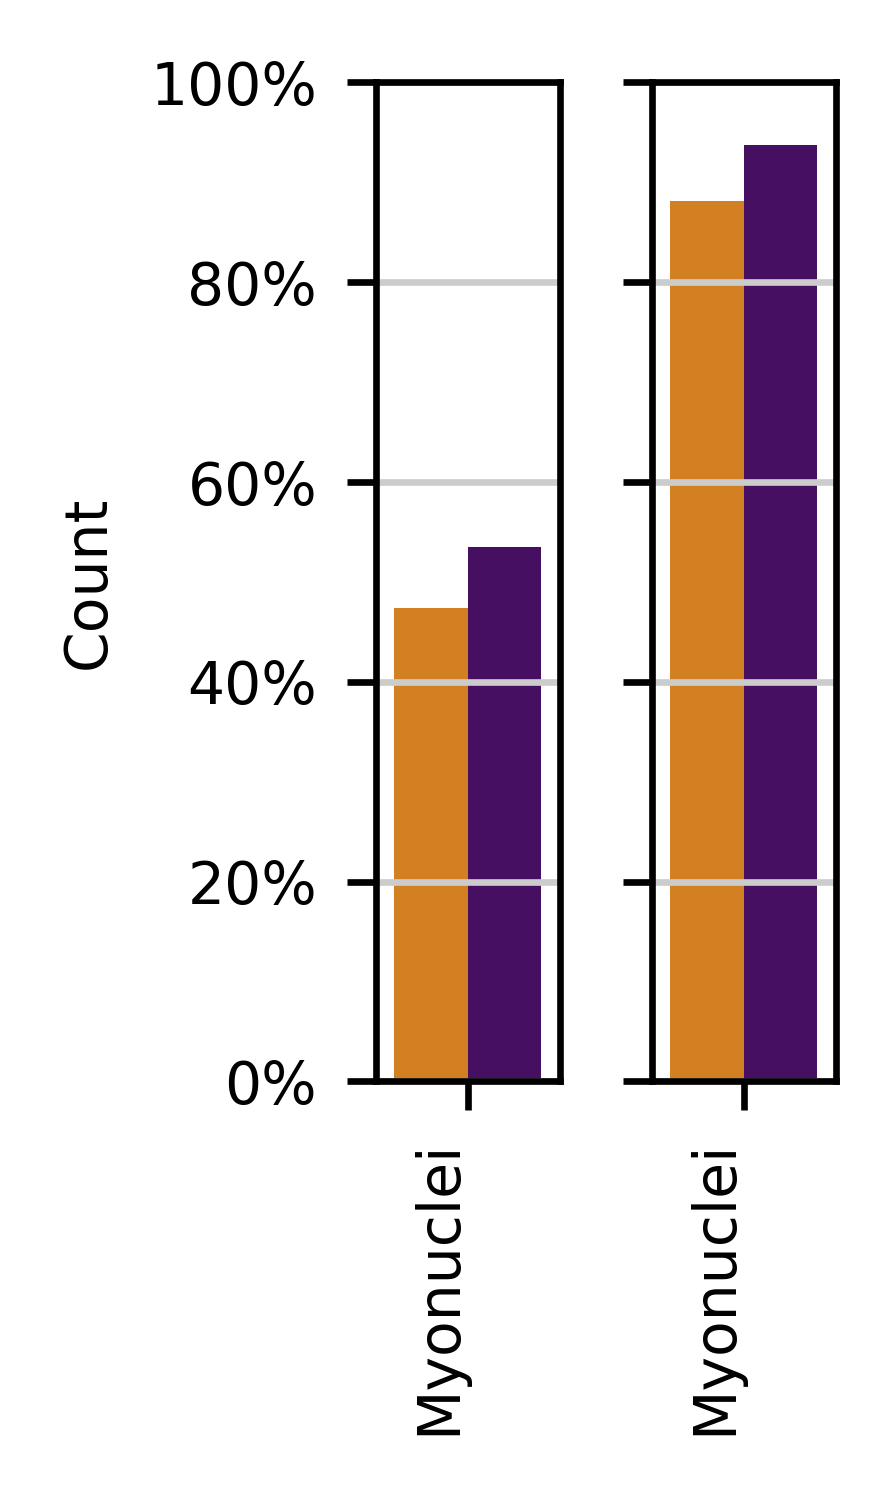

In [12]:
formatter = FuncFormatter(to_percentage)
# Define the subset of cell types to include in the plot in the specified order
cell_types_subset = ['Myonuclei']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(1.5, 2.5), dpi=300)  # Narrower figure as less content needs to be displayed
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4)  # Adjust space to optimize layout

for i, location in enumerate(np.unique(adata_dict[0].obs['injury_classification'])):
    category = location
    colors = ['#F08205', '#4C026E']
    dataset_names = ['Young', 'Geriatric']
    
    cell_type_counts = {}
    for idx, (key, adata) in enumerate(adata_dict.items()):
        adata = adata[adata.obs['injury_classification'] == category].copy()
        counts = adata.obs['max_pred_celltype'].value_counts().rename(dataset_names[idx]).filter(items=cell_types_subset)
        cell_type_counts[dataset_names[idx]] = counts / adata.uns[category] * 100
    
    # Convert the counts to a DataFrame for easier plotting
    df_counts = pd.DataFrame(cell_type_counts).fillna(0).reindex(cell_types_subset).reset_index()
    df_counts = df_counts.rename(columns={'index': 'max_pred_celltype'}).melt(id_vars='max_pred_celltype', var_name='Dataset', value_name='Count')
    
    # Plotting
    ax = axes[i]
    sns.barplot(data=df_counts, x='max_pred_celltype', y='Count', hue='Dataset', palette=colors, edgecolor=None, dodge=True, ax=ax)
    ax.set_xticklabels(['Myonuclei'], rotation=90, ha='right')  # Use long placeholder to ensure space is similar
    ax.set_ylim(0, 100)  # Setting a consistent y-axis limit
    ax.yaxis.set_major_formatter(formatter)  # Set y-axis labels to show percentages
    
    ax.legend_.remove()  # Remove the legend
    
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel(ax.get_ylabel(), fontsize=7)
    
    if i == 1:
        ax.set_ylabel('')  # Remove y-axis label for the second plot
        ax.set_yticklabels([])  # Remove y-axis tick labels for the second plot

# Adjust layout and save
plt.tight_layout()  # Auto-adjust layout
#plt.savefig('Cell_Type_Comparison_2.pdf', bbox_inches='tight', dpi=300)  # Save with tight bounding box
plt.show()  # Show the plot


### Calculate senescence score 

In [13]:
# Load senescence score genes 
senescence = pd.read_csv('/workdir/in68/Muscle/metadata/FBR_Gene_List.csv')

gene_list = senescence[senescence['logFC'] > 0]['Gene (mouse)'].astype('str')
print(gene_list)



### Filter gene list 
muscs = {}
i = 0
for adata in adata_dict.values():
    muscs[i] = adata[adata.obs['max_pred_celltype'] == 'MuSCs']
    i = i+1
sc.pp.filter_genes(muscs[0],min_cells= 2)
sc.pp.filter_genes(muscs[1],min_cells= 2)

common_genes = np.intersect1d(muscs[1].var_names.astype('str'),muscs[0].var_names.astype('str'))

score_genes = np.intersect1d(common_genes,gene_list)


sc.tl.score_genes(adata_dict[0],gene_list= score_genes, score_name= 'Senescence_score',use_raw=False,n_bins= 1000,ctrl_size=50)
sc.tl.score_genes(adata_dict[1],gene_list= score_genes, score_name= 'Senescence_score',use_raw=False, n_bins= 1000, ctrl_size=50)


0              Shisa5
5              Col6a3
8               Mmp11
9       F730043M19Rik
10              Aopep
            ...      
1785           Slc7a2
1786           Col8a1
1788             Acp5
1793             Gpc1
1796            Ddah1
Name: Gene (mouse), Length: 935, dtype: object
filtered out 10091 genes that are detected in less than 2 cells


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


filtered out 9263 genes that are detected in less than 2 cells
computing score 'Senescence_score'
    finished: added
    'Senescence_score', score of gene set (adata.obs).
    424 total control genes are used. (0:00:00)
computing score 'Senescence_score'
    finished: added
    'Senescence_score', score of gene set (adata.obs).
    365 total control genes are used. (0:00:00)


In [14]:
# Define groups for comparison
groups = {
    'Young_m': (adata_dict[0], adata_dict[0].obs['max_pred_celltype'] == 'MuSCs', 'Young', 'MuSCs_all'),
    'Geriatric_m': (adata_dict[1], adata_dict[1].obs['max_pred_celltype'] == 'MuSCs', 'Geriatric', 'MuSCs_all'),
    'Young_m_injury': (adata_dict[0], (adata_dict[0].obs['max_pred_celltype'] == 'MuSCs') & (adata_dict[0].obs['injury_classification'] == 'injury'), 'Young', 'MuSCs_injury'),
    'Geriatric_m_injury': (adata_dict[1], (adata_dict[1].obs['max_pred_celltype'] == 'MuSCs') & (adata_dict[1].obs['injury_classification'] == 'injury'), 'Geriatric', 'MuSCs_injury'),
    'Young_m_noninjury': (adata_dict[0], (adata_dict[0].obs['max_pred_celltype'] == 'MuSCs') & (adata_dict[0].obs['injury_classification'] != 'injury'), 'Young', 'MuSCs_noninjury'),
    'Geriatric_m_noninjury': (adata_dict[1], (adata_dict[1].obs['max_pred_celltype'] == 'MuSCs') & (adata_dict[1].obs['injury_classification'] != 'injury'), 'Geriatric', 'MuSCs_noninjury'),
    'Young_non': (adata_dict[0], adata_dict[0].obs['max_pred_celltype'] != 'MuSCs', 'Young', 'non_MuSCs_all'),
    'Geriatric_non': (adata_dict[1], adata_dict[1].obs['max_pred_celltype'] != 'MuSCs', 'Geriatric', 'non_MuSCs_all'),
    'Young_non_injury': (adata_dict[0], (adata_dict[0].obs['max_pred_celltype'] != 'MuSCs') & (adata_dict[0].obs['injury_classification'] == 'injury'), 'Young', 'non_MuSCs_injury'),
    'Geriatric_non_injury': (adata_dict[1], (adata_dict[1].obs['max_pred_celltype'] != 'MuSCs') & (adata_dict[1].obs['injury_classification'] == 'injury'), 'Geriatric', 'non_MuSCs_injury'),
    'Young_non_noninjury': (adata_dict[0], (adata_dict[0].obs['max_pred_celltype'] != 'MuSCs') & (adata_dict[0].obs['injury_classification'] != 'injury'), 'Young', 'non_MuSCs_noninjury'),
    'Geriatric_non_noninjury': (adata_dict[1], (adata_dict[1].obs['max_pred_celltype'] != 'MuSCs') & (adata_dict[1].obs['injury_classification'] != 'injury'), 'Geriatric', 'non_MuSCs_noninjury')
}

# Extract data and compare each Young vs Geriatric group
final_data = []
comparisons = [
    ('Young_m', 'Geriatric_m'),
    ('Young_m_injury', 'Geriatric_m_injury'),
    ('Young_m_noninjury', 'Geriatric_m_noninjury'),
    ('Young_non', 'Geriatric_non'),
    ('Young_non_injury', 'Geriatric_non_injury'),
    ('Young_non_noninjury', 'Geriatric_non_noninjury')
]

# Loop through each comparison, extract data, plot, and calculate statistics
for group1, group2 in comparisons:
    df1 = extract_data(*groups[group1])
    df2 = extract_data(*groups[group2])
    final_data.append(df1)
    final_data.append(df2)
    
    print(f"\nComparing {group1} vs {group2}")
    # print(f"{group1}: Mean = {np.mean(df1['Senescence_score'])}, Median = {np.median(df1['Senescence_score'])}, N = {len(df1)}")
    # print(f"{group2}: Mean = {np.mean(df2['Senescence_score'])}, Median = {np.median(df2['Senescence_score'])}, N = {len(df2)}")
    
    # plot_boxplot_for_arrays(df1['Senescence_score'], df2['Senescence_score'], array_1=group1, array_2=group2)
    
    results = compare_datasets(df1['Senescence_score'], df2['Senescence_score'], n_comparisons=1)
    for test, value in results.items():
        print(f"{test}: {value}")

# Combine all data into a single DataFrame
final_df = pd.concat(final_data)

# Reorder columns
final_df = final_df[['cell_name', 'age', 'location', 'Senescence_score']]

# Export to CSV
final_df.to_csv('senescence_scores.csv', index=False)

print("Data has been written to senescence_scores.csv")



Comparing Young_m vs Geriatric_m
T-Test P-Value: 9.62e-03
Mann-Whitney U P-Value: 1.58e-02
Wilcoxon Rank-Sum P-Value: 1.57e-02
Mean Data1: 0.010392176645366642
Mean Data2: 0.06418268666506782
Median Data1: 0.001953323136880923
Median Data2: 0.054117334586745613

Comparing Young_m_injury vs Geriatric_m_injury
T-Test P-Value: 1.69e-02
Mann-Whitney U P-Value: 3.15e-02
Wilcoxon Rank-Sum P-Value: 3.14e-02
Mean Data1: 0.015838062119115894
Mean Data2: 0.06996550488300587
Median Data1: 0.011942700088330857
Median Data2: 0.05713989174974662

Comparing Young_m_noninjury vs Geriatric_m_noninjury
T-Test P-Value: 6.97e-01
Mann-Whitney U P-Value: 7.33e-01
Wilcoxon Rank-Sum P-Value: 7.26e-01
Mean Data1: -0.0032225370390064853
Mean Data2: 0.017920140921563462
Median Data1: -0.038016457807138464
Median Data2: -0.024766057306624595

Comparing Young_non vs Geriatric_non
T-Test P-Value: 4.15e-29
Mann-Whitney U P-Value: 7.53e-38
Wilcoxon Rank-Sum P-Value: 7.53e-38
Mean Data1: -0.03213643101467904
Mean Dat

/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/in68/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

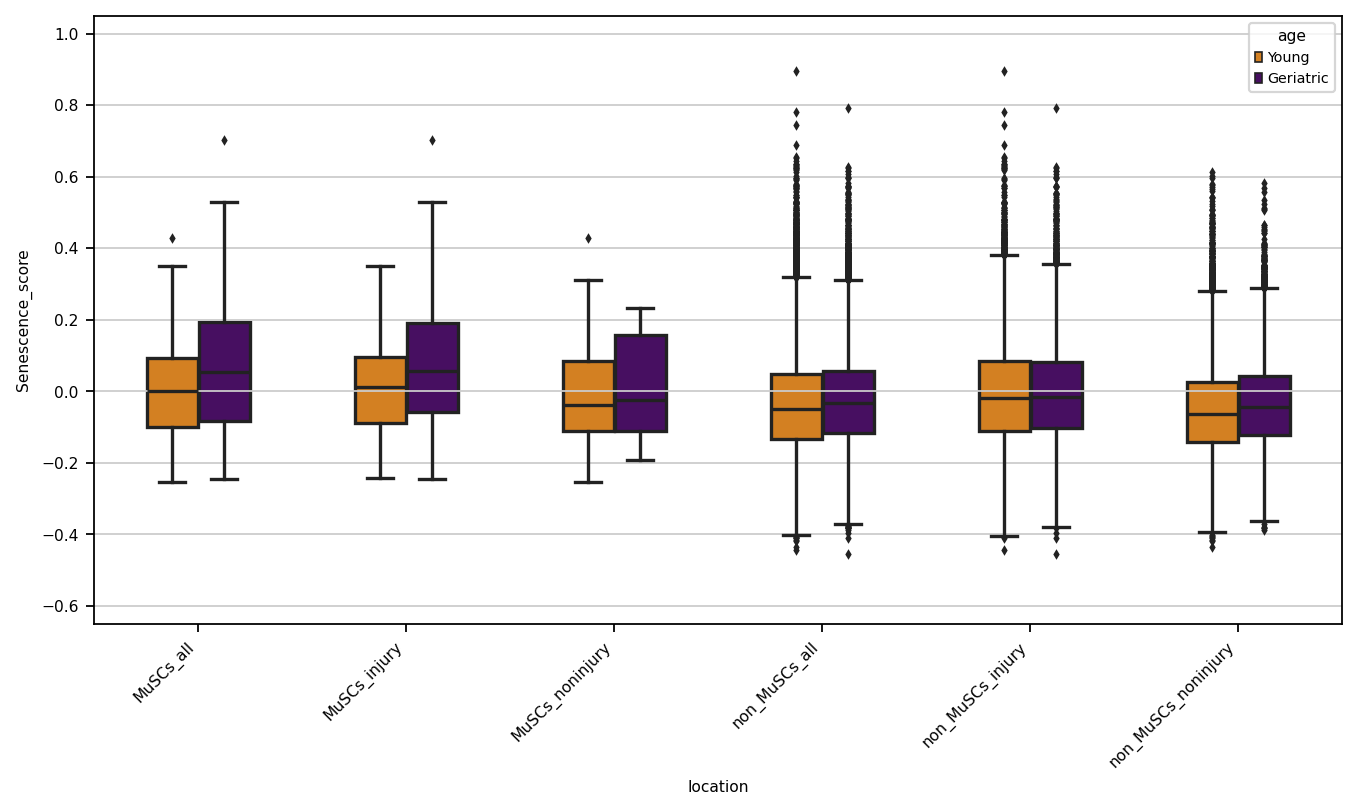

In [15]:
# Define the colors
colors = ['#F08205', '#4C026E']

# Create the seaborn box plot with specified colors and adjust box width and outlier size
ax = sns.boxplot(data=final_df, x="location", y='Senescence_score', hue="age", palette=colors, width=0.5, fliersize=2)

# Make outliers slightly transparent
for artist in ax.artists:
    artist.set_edgecolor('black')  # Set outlier edge color to black
    for line in artist.get_lines():
        line.set_alpha(0.1)  # Set outlier transparency to 0.5

# Remove legends
#plt.legend().remove()

# Set figure size
plt.gcf().set_size_inches(10, 5)

# Customize y-axis display
plt.yticks(fontsize=7)
plt.gca().set_ylim([-0.65, 1.05])  # Set the y-axis limits
plt.gca().set_yticks([-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8,1.0])  # Set y-axis ticks

#Give angle to x labels
plt.xticks(rotation=45, ha='right', fontsize=7)
# Save the figure as PDF with high resolution
#plt.savefig("box_plot.pdf", dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()


In [ ]:
### Save source data for figure 

### Full size spatial plots

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/mi

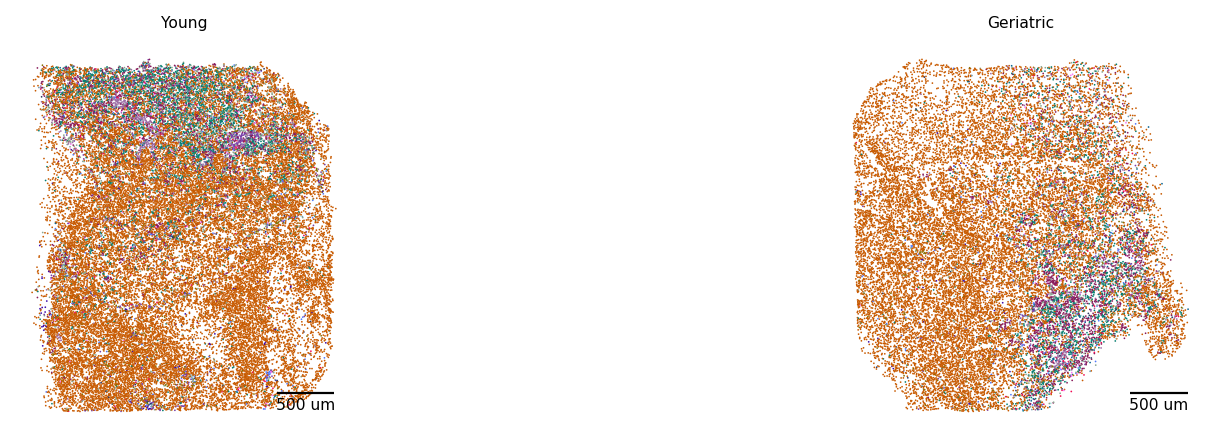

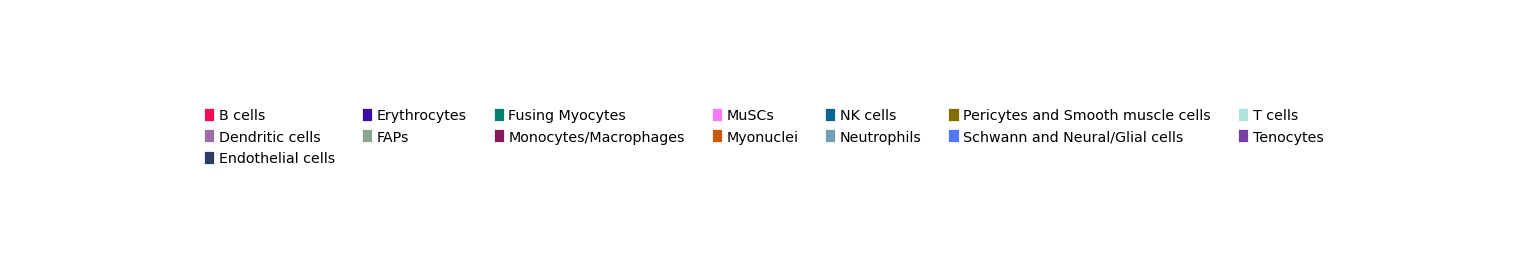

In [16]:
titles = ['Young', 'Geriatric']

plot_spatial_data(adata_dict, obs=['max_pred_celltype'], titles=titles,  spot_size=15)


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/mi

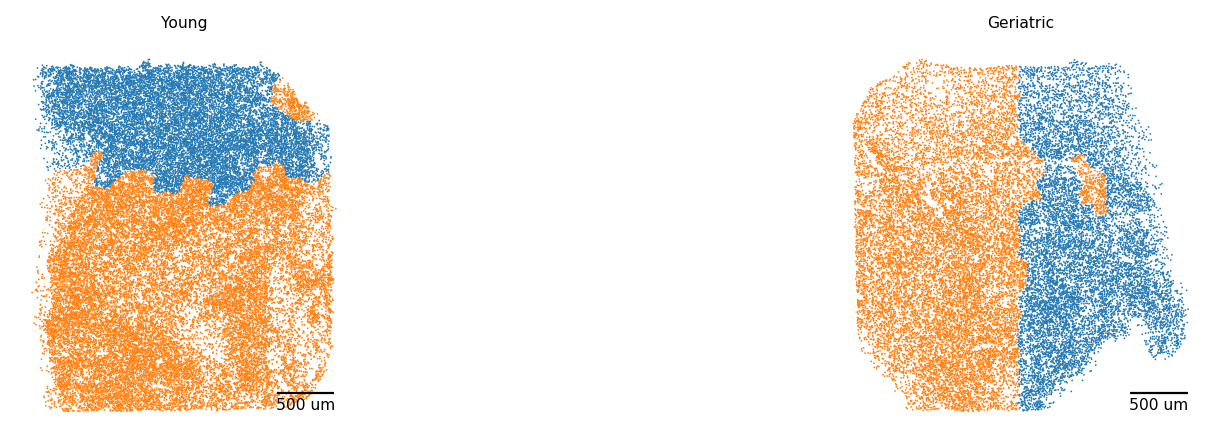

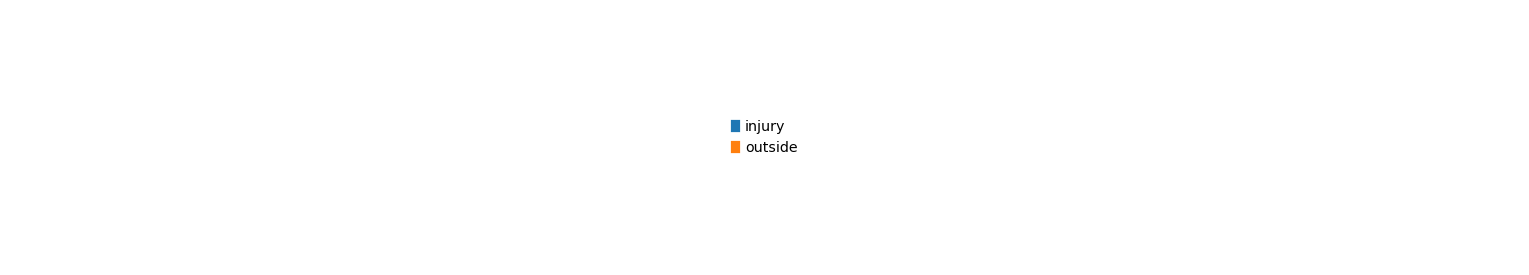

In [17]:
titles = ['Young', 'Geriatric']

plot_spatial_data(adata_dict, obs=['injury_classification'], titles=titles,  spot_size=15)


### Zoomed-in plots

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/mi

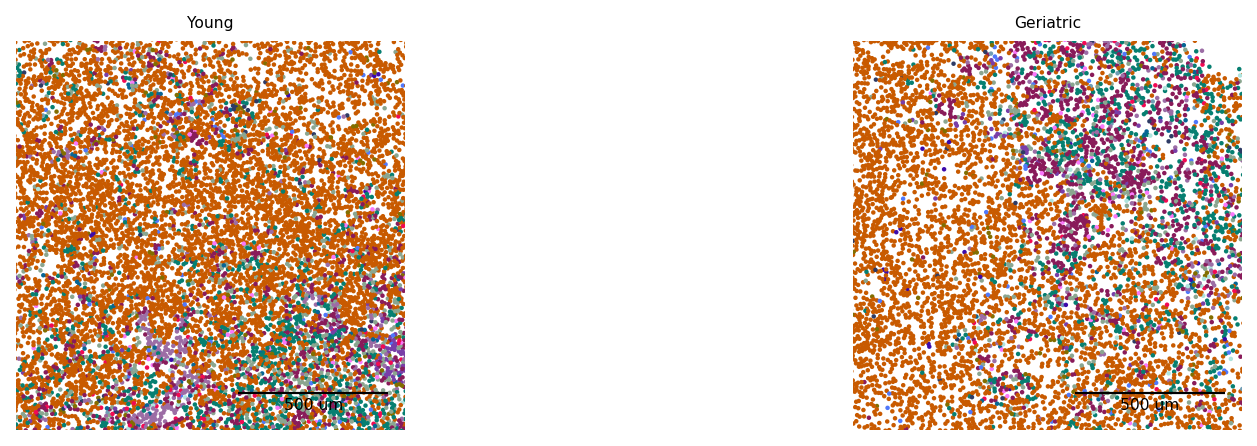

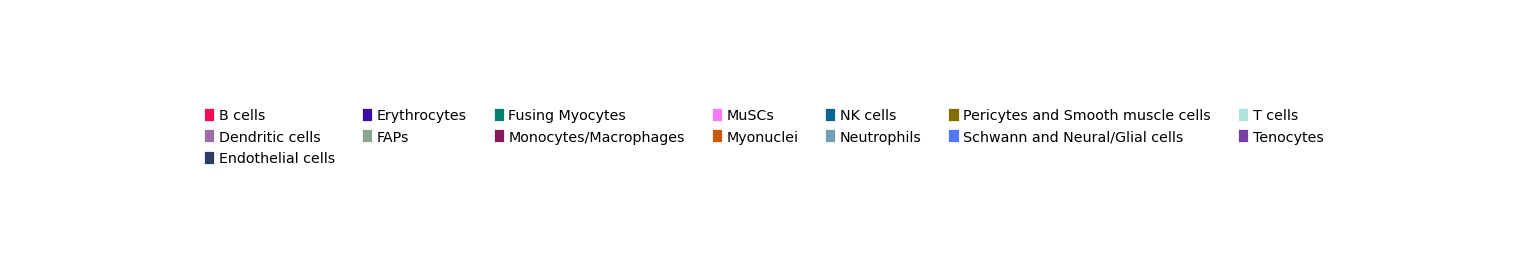

In [18]:


crop = {0: [1500, 2800, 2000, 700], 1: [1500, 2800, 2800, 1500]}
titles = ['Young', 'Geriatric']

plot_spatial_data(adata_dict, obs=['max_pred_celltype'], titles=titles, crop=crop, spot_size=15)


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/mi

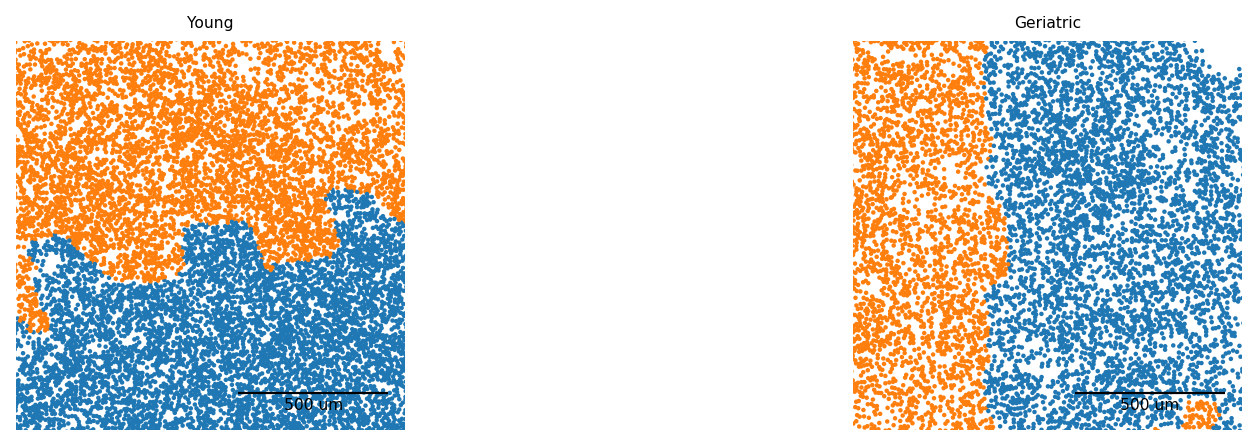

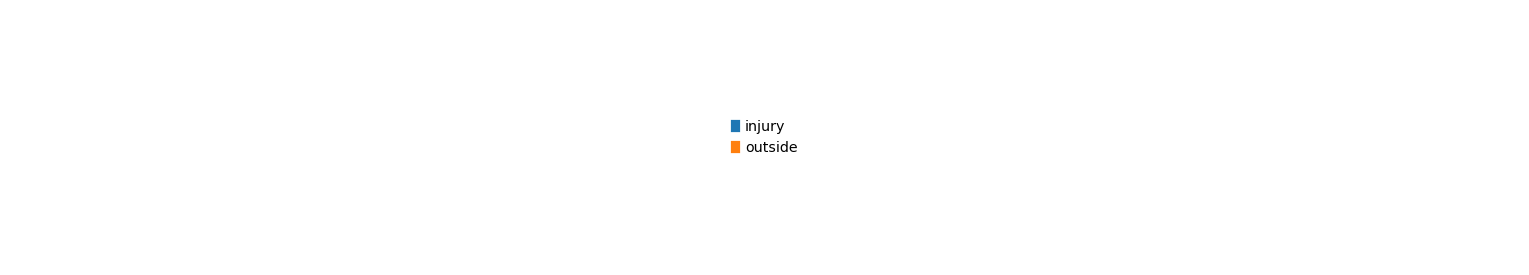

In [19]:
crop = {0: [1500, 2800, 2000, 700], 1: [1500, 2800, 2800, 1500]}
titles = ['Young', 'Geriatric']
plot_spatial_data(adata_dict, obs=['injury_classification'], titles=titles, crop=crop,spot_size=15)


/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


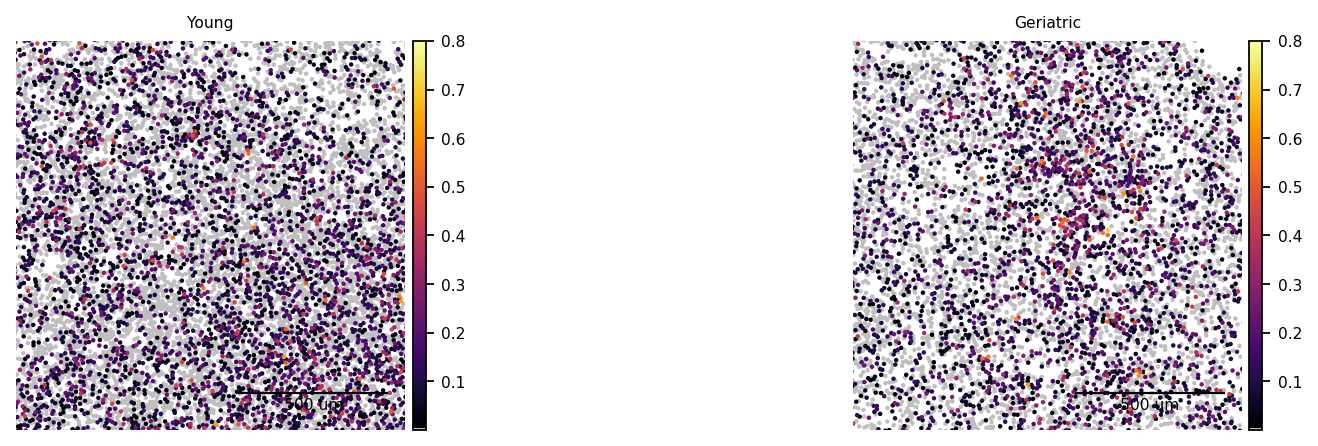

In [20]:

crop = {0: [1500, 2800, 2000, 700], 1: [1500, 2800, 2800, 1500]}
titles = ['Young', 'Geriatric']
plot_spatial_data(adata_dict, obs=['Senescence_score'], titles=titles, crop=crop, cmap=newcmp4, vmin=0.0000001, vmax=0.8, spot_size=15)


In [21]:
adata_dict[0].write_h5ad('/fs/cbsuvlaminck2/workdir/in68/Muscle/out/Sample11/Young_TA_ST_5dpi_pp.h5ad')
adata_dict[1].write_h5ad('/fs/cbsuvlaminck2/workdir/in68/Muscle/out/Sample12/Geriatric_TA_ST_5dpi_pp.h5ad')